In [118]:
import torch
import pandas as pd
from datasets import Dataset
from transformers import EarlyStoppingCallback
from sklearn import preprocessing
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from huggingface_hub import notebook_login
import numpy as np
import matplotlib.pyplot as plt
import evaluate

Encode labels

In [119]:
df = pd.read_csv("data/data.csv", index_col=0)

label_encoder = preprocessing.LabelEncoder()
df['labels'] = label_encoder.fit_transform(df['labels'])
df

,text,labels
0,My purpose here is to offer a defence of exist...,0
1,dwell in quietism of despair. For if every way...,0
2,arrive finally at a contemplative philosophy. ...,0
3,quarter we are reproached for having underline...,0
4,possess charm and beauty and belong to the bri...,0
...,...,...
33099,"if complied with, is to 'deprive and divest hi...",3
33100,"mention the species opposed to imprisonment, i...",3
33101,"protecting property, and of pursuing and obtai...",3
33102,"for, the necessary effect of such an order is ...",3


## Creating train/test splits

Loading the model and tokenizer, checking input/output

In [121]:
id2label = {i: label for i, label in enumerate(label_encoder.classes_)}
label2id = {label: i for i, label in enumerate(label_encoder.classes_)}
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', 
                                                            num_labels=4,
                                                            id2label=id2label,
                                                            label2id=label2id)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
input = df['text'][0]
encoded_input = tokenizer(input, return_tensors='pt')
output = model(**encoded_input)
print(f"\n{input=}")
print(f"\n{encoded_input=}")
print(f"\n{output=}")

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 650.10it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



input='My purpose here is to offer a defence of existentialism against several reproaches that have been laid against it. First, it has been reproached as an invitation to people to'

encoded_input={'input_ids': tensor([[  101,  2026,  3800,  2182,  2003,  2000,  3749,  1037,  4721,  1997,
         25953,  4818,  2964,  2114,  2195, 16360,  3217, 15395,  2015,  2008,
          2031,  2042,  4201,  2114,  2009,  1012,  2034,  1010,  2009,  2038,
          2042, 16360,  3217, 15395,  2094,  2004,  2019,  8468,  2000,  2111,
          2000,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

output=SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0988, -0.0101, -0.0293, -0.1599]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [122]:
#X_train, X_text, y_train, y_text = train_test_split(df['entry'], df['label'], test_size=0.2, random_state=42)
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2, shuffle=True)
def tokenize(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
dataset

Map: 100%|██████████| 6621/6621 [00:00<00:00, 12333.17 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 26483
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 6621
    })
})

In [123]:
metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels, average='weighted')

In [124]:
training_args = TrainingArguments(
    output_dir="checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=20,
    learning_rate=2e-5,
    optim='stable_adamw',
    load_best_model_at_end=True,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    processing_class=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()
trainer.save_model('model')
tokenizer.save_pretrained('model')

/Users/agustinlorenzjo/Developer/phil-class/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

## Analyze results with confusion matrix

/Users/agustinlorenzjo/Developer/phil-class/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


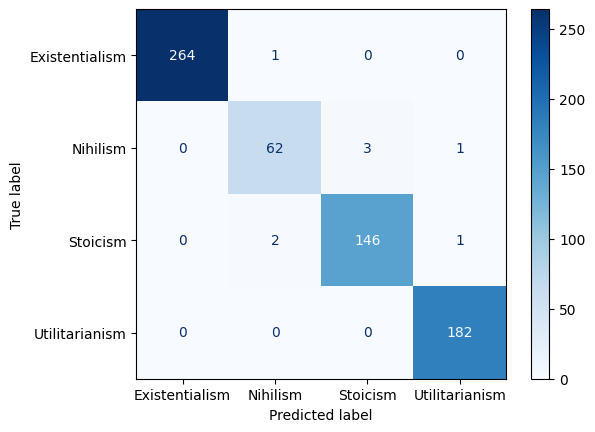

In [106]:
predictions = trainer.predict(dataset['test'])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

label_names = ["Existentialism", "Nihilism", "Stoicism", "Utilitarianism"]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)

Test model trained successfully! Before adjusting any hyperparameters for improving performance, accuracy seems to be a little above 50% (better than expected accuracy of a random guesser, 20%).

In [111]:
existentialism = "Man is condemned to be free; because once thrown into the world, he is responsible for everything he does. It is up to you to give life a meaning. To choose to be this or that is to affirm at the same time the value of what we choose."
stoicism = "Being a stoic does not mean being a robot. Being a stoic means remaining calm both at the height of pleasure and the depths of misery."
util = "argument for preferring the life of a human being to that of an animal (with which most modern readers would be quite comfortable) is exactly paralleled by his argument for preferring the life of an intelligent human being to that of fool."
nihilism = "Life is just a glitch in a cold, dead universe."

pipe = pipeline('text-classification', 'model')
pred_exist = pipe(existentialism)
pred_stoic = pipe(stoicism)
pred_util = pipe(util)
pred_nihilism = pipe(nihilism)

print(f"{pred_exist = }")
print(f"{pred_stoic = }")
print(f"{pred_util = }")
print(f"{pred_nihilism = }")

Loading weights: 100%|██████████| 104/104 [00:00<00:00, 1119.98it/s, Materializing param=pre_classifier.weight]                                  


pred_exist = [{'label': 'existentialism', 'score': 0.9990699887275696}]
pred_stoic = [{'label': 'stoicism', 'score': 0.9996989965438843}]
pred_util = [{'label': 'utilitarianism', 'score': 0.9997583031654358}]
pred_nihilism = [{'label': 'nihilism', 'score': 0.9981322884559631}]


Correctly guessed absurdism and existentialism!

In [117]:
notebook_login()

model.push_to_hub("agustin-lorenzo/Philosophy-Classifier")
tokenizer.push_to_hub("agustin-lorenzo/Philosophy-Classifier")

Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]
Processing Files (1 / 1): 100%|██████████|  268MB /  268MB, 16.1MB/s  
New Data Upload: 100%|██████████|  268MB /  268MB, 16.1MB/s  


CommitInfo(commit_url='https://huggingface.co/agustin-lorenzo/Philosophy-Classifier/commit/0cff3d2ea99bfac54dcff64c220a3ddfc1e94e07', commit_message='Upload tokenizer', commit_description='', oid='0cff3d2ea99bfac54dcff64c220a3ddfc1e94e07', pr_url=None, repo_url=RepoUrl('https://huggingface.co/agustin-lorenzo/Philosophy-Classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='agustin-lorenzo/Philosophy-Classifier'), pr_revision=None, pr_num=None)